# Setup

In [1]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [4]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-05-25 14:25:28.162711: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 14:25:28.820917: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-25 14:25:28.820980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30976 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:25:00.0, compute capability: 7.0


In [5]:
config = json.load(open("config.json"))

# Loading data

In [6]:
from data_loader.abo import ABO

In [7]:
data = ABO(
    path=config["data"]["path"],
    download=True,
    extract=False,
    preprocess=True,
    alt_augment=False,
    random_deletion=True,
    export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Performing random deletion...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,beddingamazon brand - symbol men's tan pu form...,19/194721fd.jpg,SHOES,0
1,b0843ygxnhleone men's blue running shoes-6 uk ...,6e/6e76fc9b.jpg,SHOES,1
2,scrubber^skin scrubber^facial skin scrubber^ul...,f3/f3e6f2d8.jpg,THERMOS,0
3,b07r5vblsl,78/78043759.jpg,CELLULAR_PHONE_CASE,1
4,mobile coverb07t8q1nj4amazon brand - solimo de...,0c/0c80275c.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
141821,b08563xylv,7c/7cdc4462.jpg,CELLULAR_PHONE_CASE,1
141822,"rivet ava mid-century modern ottoman, 25.6"" w,...",58/58498433.jpg,HOME_FURNITURE_AND_DECOR,1
141823,"365 everyday value, black bean & corn salsa, 1...",61/61c6691e.jpg,CELLULAR_PHONE_CASE,0
141824,mobile coveramazon brand - solimo designer lad...,9e/9e8d3f7d.jpg,CELLULAR_PHONE_CASE,0


In [8]:
img = data[["path"]] # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [9]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(141826, 1014)

## Create embedding weights

In [10]:
weights = tk.create_embedding_weights()
weights.shape

(65, 64)

# Image processing

## Load image model

In [11]:
from utils.img_processing import load_img_model, create_embeddings_from

In [12]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [13]:
# batch_size = 1024 -> 8,5 GB VRAM
# batch_size = 2048 -> 17 GB VRAM
# ...

img = create_embeddings_from(img_model, img, os.path.join(config["data"]["path"], "images/small"), batch_size=2048)

Found 141826 validated image filenames.


2023-05-25 14:25:55.171959: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8901


In [14]:
img.shape

(141826, 576)

# Save embeddings

In [15]:
save_path = os.path.join(config["data"]["path"], "embeddings")

In [16]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [17]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,beddingamazon brand - symbol men's tan pu form...,19/194721fd.jpg,SHOES,0
1,b0843ygxnhleone men's blue running shoes-6 uk ...,6e/6e76fc9b.jpg,SHOES,1
2,scrubber^skin scrubber^facial skin scrubber^ul...,f3/f3e6f2d8.jpg,THERMOS,0
3,b07r5vblsl,78/78043759.jpg,CELLULAR_PHONE_CASE,1
4,mobile coverb07t8q1nj4amazon brand - solimo de...,0c/0c80275c.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
141821,b08563xylv,7c/7cdc4462.jpg,CELLULAR_PHONE_CASE,1
141822,"rivet ava mid-century modern ottoman, 25.6"" w,...",58/58498433.jpg,HOME_FURNITURE_AND_DECOR,1
141823,"365 everyday value, black bean & corn salsa, 1...",61/61c6691e.jpg,CELLULAR_PHONE_CASE,0
141824,mobile coveramazon brand - solimo designer lad...,9e/9e8d3f7d.jpg,CELLULAR_PHONE_CASE,0


In [18]:
img = np.load(f"{save_path}/img.npy")
img.shape

(141826, 576)

In [19]:
text = np.load(f"{save_path}/text.npy")
text.shape

(141826, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [20]:
data["product_type_count"] = data.groupby(["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [21]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train, test, labels_train, labels_test = train_test_split(data, labels, stratify=product_types, test_size=config["mnn_em"]["training"]["test_split"], random_state=42)

In [24]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

In [25]:
from models.char_cnn_zhang import CharCNNZhang

In [26]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [27]:
# txt_model = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

In [28]:
from models.mnn_em import MNNEM
from utils.eval import create_metrics

In [29]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "txt_weights": weights,
    "char_cnn_config": char_cnn_config,
    "img_fc_layers": config["mnn_em"]["img_fc_layers"],
    "txt_fc_layers": config["mnn_em"]["txt_fc_layers"],
}

In [30]:
mnn_em = MNNEM(
    head_config=head_config,
    combined_fc_layers=config["mnn_em"]["combined_fc_layers"],
    learning_rate=config["mnn_em"]["training"]["learning_rate"],
    metrics=create_metrics(config["mnn_em"]["training"]["metrics"]))

In [31]:
mnn_em.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 512)          17171008    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
                                                                                                  
 Combined_FC_1 (Dense)          (None, 512)          262656      ['MNN_EM_Head[0][0]']        

In [32]:
tf.keras.utils.plot_model(mnn_em.model, rankdir="TB", show_layer_activations=True, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Callbacks

In [36]:
from utils.eval import create_callbacks

In [37]:
model_name = config["mnn_em"]["name"]
optimizer_name = config["mnn_em"]["training"]["optimizer"]
learning_rate = config["mnn_em"]["training"]["learning_rate"]

In [38]:
callbacks = create_callbacks(
    callbacks_list=config["mnn_em"]["training"]["callbacks"],
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"]
    )

# Training

In [39]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["mnn_em"]["training"]["epochs"],
    validation_split=config["mnn_em"]["training"]["validation_split"],
    batch_size=config["mnn_em"]["training"]["batch_size"], 
callbacks=callbacks)


Epoch 1/10
7179/7179 [==============================] - ETA: 0s - loss: 1.0198 - recall: 0.8776 - precision: 0.6712 - binary_accuracy: 0.7242 - cosine_similarity: 0.4993

2023-05-25 14:33:48.026945: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7179/7179 [==============================] - 76s 10ms/step - loss: 1.0198 - recall: 0.8776 - precision: 0.6712 - binary_accuracy: 0.7242 - cosine_similarity: 0.4993 - val_loss: 0.4761 - val_recall: 0.8910 - val_precision: 0.7360 - val_binary_accuracy: 0.7833 - val_cosine_similarity: 0.5055
Epoch 2/10
7175/7179 [============================>.] - ETA: 0s - loss: 0.4344 - recall: 0.9394 - precision: 0.7400 - binary_accuracy: 0.8049 - cosine_similarity: 0.4992

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7179/7179 [==============================] - 70s 10ms/step - loss: 0.4344 - recall: 0.9394 - precision: 0.7400 - binary_accuracy: 0.8050 - cosine_similarity: 0.4993 - val_loss: 0.3943 - val_recall: 0.9741 - val_precision: 0.7557 - val_binary_accuracy: 0.8278 - val_cosine_similarity: 0.5055
Epoch 3/10
7175/7179 [============================>.] - ETA: 0s - loss: 0.3891 - recall: 0.9439 - precision: 0.7736 - binary_accuracy: 0.8341 - cosine_similarity: 0.4992

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7179/7179 [==============================] - 72s 10ms/step - loss: 0.3891 - recall: 0.9439 - precision: 0.7736 - binary_accuracy: 0.8341 - cosine_similarity: 0.4992 - val_loss: 0.3745 - val_recall: 0.9211 - val_precision: 0.8066 - val_binary_accuracy: 0.8484 - val_cosine_similarity: 0.5055
Epoch 4/10
7177/7179 [============================>.] - ETA: 0s - loss: 0.3477 - recall: 0.9503 - precision: 0.8038 - binary_accuracy: 0.8594 - cosine_similarity: 0.4993

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7179/7179 [==============================] - 72s 10ms/step - loss: 0.3477 - recall: 0.9503 - precision: 0.8038 - binary_accuracy: 0.8594 - cosine_similarity: 0.4993 - val_loss: 0.3381 - val_recall: 0.9495 - val_precision: 0.8213 - val_binary_accuracy: 0.8700 - val_cosine_similarity: 0.5055
Epoch 5/10
7179/7179 [==============================] - 69s 10ms/step - loss: 0.3257 - recall: 0.9599 - precision: 0.8142 - binary_accuracy: 0.8706 - cosine_similarity: 0.4993 - val_loss: 0.3466 - val_recall: 0.9502 - val_precision: 0.8214 - val_binary_accuracy: 0.8704 - val_cosine_similarity: 0.5055
Epoch 6/10
7177/7179 [============================>.] - ETA: 0s - loss: 0.3099 - recall: 0.9645 - precision: 0.8211 - binary_accuracy: 0.8773 - cosine_similarity: 0.4993

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7179/7179 [==============================] - 73s 10ms/step - loss: 0.3099 - recall: 0.9645 - precision: 0.8211 - binary_accuracy: 0.8773 - cosine_similarity: 0.4992 - val_loss: 0.3116 - val_recall: 0.9614 - val_precision: 0.8291 - val_binary_accuracy: 0.8803 - val_cosine_similarity: 0.5054
Epoch 7/10
7179/7179 [==============================] - 69s 10ms/step - loss: 0.2970 - recall: 0.9664 - precision: 0.8273 - binary_accuracy: 0.8825 - cosine_similarity: 0.4993 - val_loss: 0.3183 - val_recall: 0.9495 - val_precision: 0.8361 - val_binary_accuracy: 0.8803 - val_cosine_similarity: 0.5054
Epoch 8/10
7177/7179 [============================>.] - ETA: 0s - loss: 0.2845 - recall: 0.9685 - precision: 0.8343 - binary_accuracy: 0.8882 - cosine_similarity: 0.4993

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7179/7179 [==============================] - 73s 10ms/step - loss: 0.2845 - recall: 0.9685 - precision: 0.8343 - binary_accuracy: 0.8883 - cosine_similarity: 0.4993 - val_loss: 0.3046 - val_recall: 0.9659 - val_precision: 0.8344 - val_binary_accuracy: 0.8858 - val_cosine_similarity: 0.5055
Epoch 9/10
7179/7179 [==============================] - 69s 10ms/step - loss: 0.2706 - recall: 0.9673 - precision: 0.8422 - binary_accuracy: 0.8932 - cosine_similarity: 0.4993 - val_loss: 0.3161 - val_recall: 0.9544 - val_precision: 0.8417 - val_binary_accuracy: 0.8862 - val_cosine_similarity: 0.5054
Epoch 10/10
7179/7179 [==============================] - 69s 10ms/step - loss: 0.2547 - recall: 0.9676 - precision: 0.8513 - binary_accuracy: 0.8994 - cosine_similarity: 0.4993 - val_loss: 0.3425 - val_recall: 0.9302 - val_precision: 0.8398 - val_binary_accuracy: 0.8750 - val_cosine_similarity: 0.5053


# Evaluation

## Plot loss and metrics

In [40]:
from utils.eval import plot_metrics

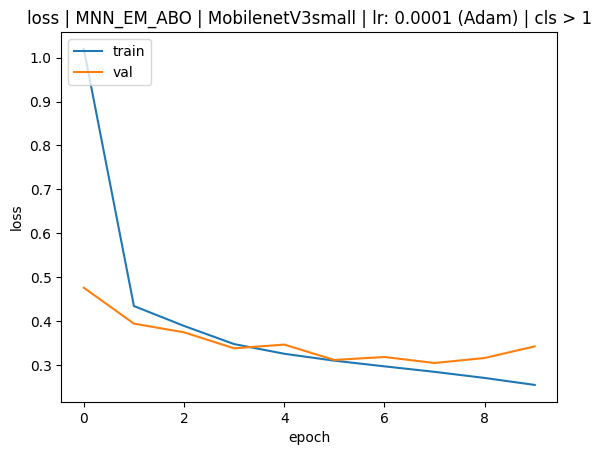

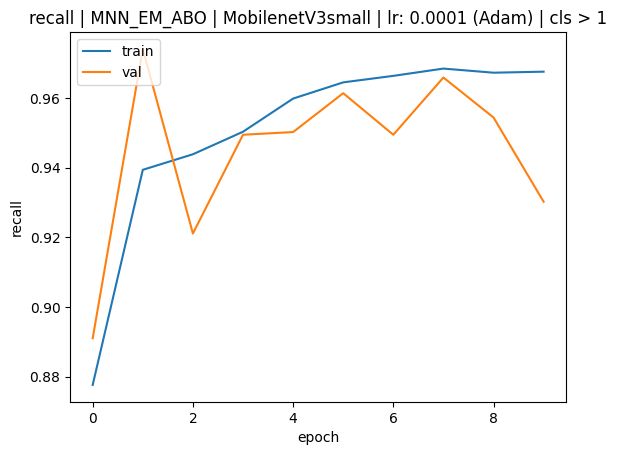

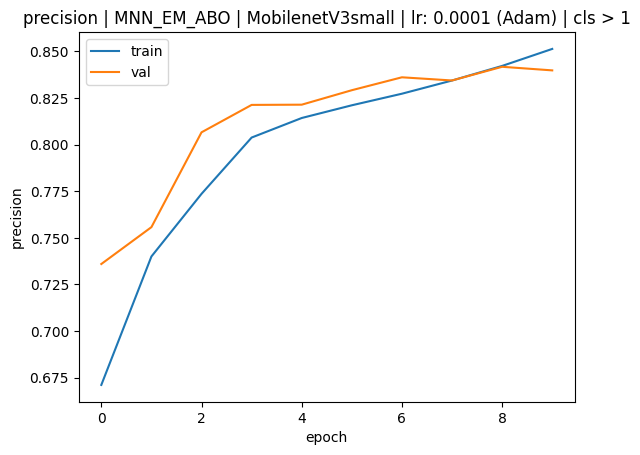

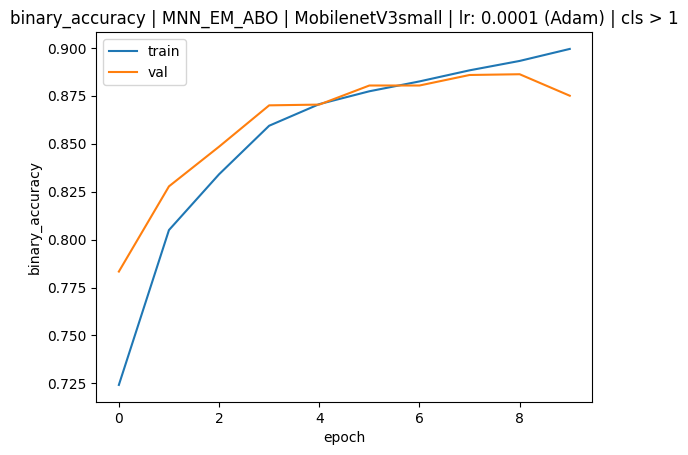

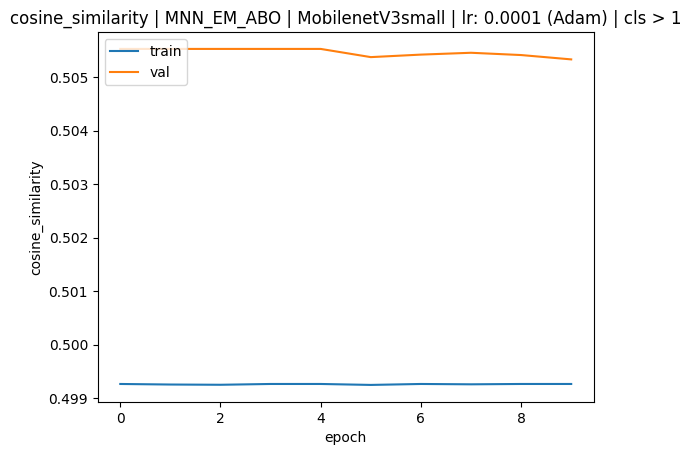

In [41]:
plot_metrics(history.history, config["mnn_em"]["training"]["metrics"], model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

## Evaluate model and save metrics

In [42]:
from utils.eval import evaluate

In [43]:
evaluate(mnn_em.model, img_test, text_test, labels_test, model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

14179/14179 [==============================] - 40s 3ms/step - loss: 0.3517 - recall: 0.9225 - precision: 0.8336 - binary_accuracy: 0.8702 - cosine_similarity: 0.4960
